## Analysis of stratified drug response regression

In these experiments train and test sets are stratified by cancer type. We're trying to predict continuous $\log($IC50$)$ values here, as opposed to the classification experiments where we were trying to predict resistant or sensitive status for each cell line.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot as up

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

### Load results from files

In [2]:
# analysis of results generated by script:
# 01_stratified_classification/run_stratified_classification.py
# (with varying feature_selection parameters)

results_dir = os.path.join('results', 'drug_response_stratified_regression')

n_dims = [100, 250, 500, 1000, 5000]

fs_methods = [
    'mad',
    'pancan_f_test',
    'median_f_test',
    'random'
]

In [3]:
results_df = au.load_prediction_results_fs(results_dir,
                                           cfg.fs_methods,
                                           classify=False,
                                           identifier_from_fname=True)

for n in n_dims:
    for fs_method in fs_methods:
        results_df.loc[
            (results_df.fs_method == fs_method) & 
            (results_df.n_dims == n),
            'fs_method'
        ] = '{}.{}'.format(fs_method, n)

results_df = (results_df
  .rename(columns={'identifier': 'drug',
                   'fold_no': 'fold'})
)

print(results_df.shape)
print(results_df.fs_method.unique())
print(results_df.n_dims.unique())
results_df.head()

(6720, 12)
['mad.100' 'median_f_test.5000' 'random.5000' 'random.100' 'mad.5000'
 'mad.500' 'pancan_f_test.5000' 'pancan_f_test.500' 'median_f_test.250'
 'random.500' 'pancan_f_test.1000' 'mad.1000' 'random.1000'
 'median_f_test.500' 'random.250' 'median_f_test.100' 'pancan_f_test.250'
 'median_f_test.1000' 'pancan_f_test.100' 'mad.250']
[ 100 5000  500  250 1000]


,mse,rmse,r2,pearson,spearman,data_type,drug,signal,seed,fold,fs_method,n_dims
0,0.76528,0.8748,0.421010,0.691810,0.575760,train,Erlotinib,signal,42,0,mad.100,100
1,1.27950,1.1312,0.031952,0.255210,0.212880,cv,Erlotinib,signal,42,0,mad.100,100
2,1.25210,1.1190,-0.134980,0.070271,-0.115760,test,Erlotinib,signal,42,0,mad.100,100
3,1.01630,1.0081,0.108920,0.444040,0.368330,train,Erlotinib,signal,42,1,mad.100,100
4,1.12940,1.0627,0.009795,0.106700,0.088594,cv,Erlotinib,signal,42,1,mad.100,100


### Signal vs. shuffled performance

In these plots we'll take a single dimensionality and compare the model with true labels to the model with shuffled/permuted labels, to get an idea of how well the permuted model is performing.

We'll do this for 3 performance metrics: RMSE, $R^2$, and Spearman correlation.

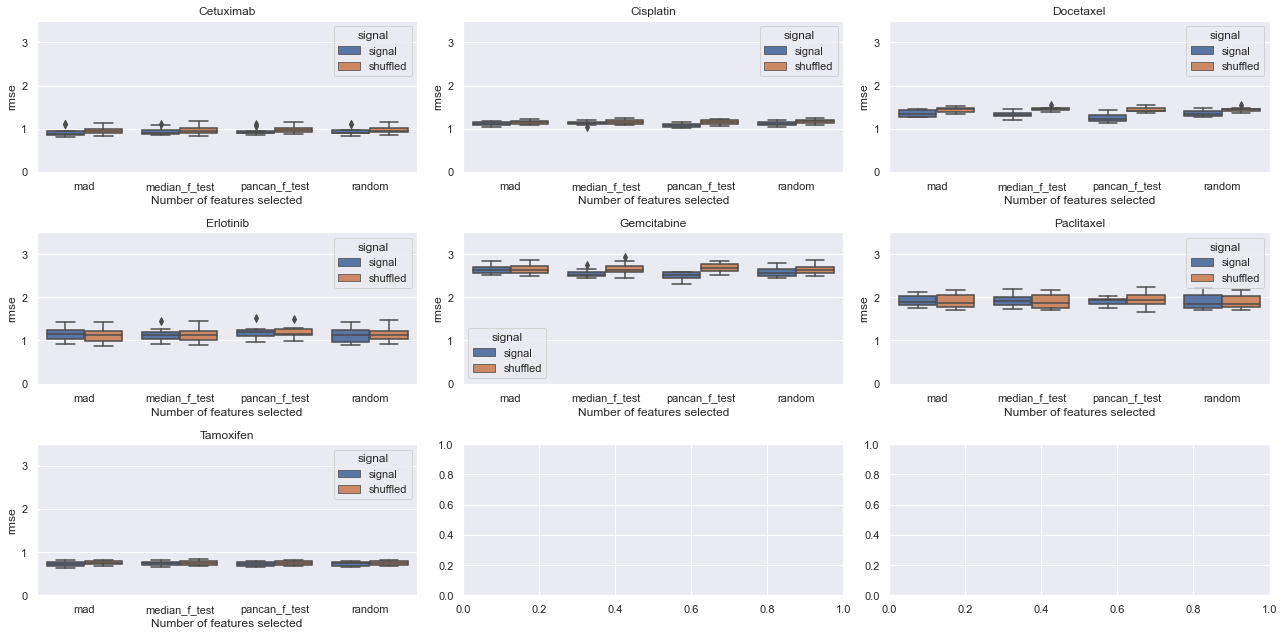

In [4]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(3, 3)

n_dims = 100
fs_method_order = [
    'mad',
    'pancan_f_test',
    'median_f_test',
    'random'
]
signal_order = ['signal', 'shuffled']

results_df.sort_values(by=['drug', 'fs_method'], inplace=True)
for ix, drug in enumerate(results_df.drug.unique()):
    ax = axarr[ix // 3, ix % 3]
    plot_df = results_df[(results_df.drug == drug) &
                         (results_df.n_dims == n_dims) &
                         (results_df.data_type == 'test')].copy()
    plot_df.loc[:, 'fs_method'] = plot_df.fs_method.str.split('.', 1, expand=True)[0]
    sns.boxplot(data=plot_df, x='fs_method', y='rmse',
                hue='signal', hue_order=signal_order,
                ax=ax)
    ax.set_title(drug)
    ax.set_xlabel('Number of features selected')
    ax.set_ylim(0, 3.5)

plt.tight_layout()

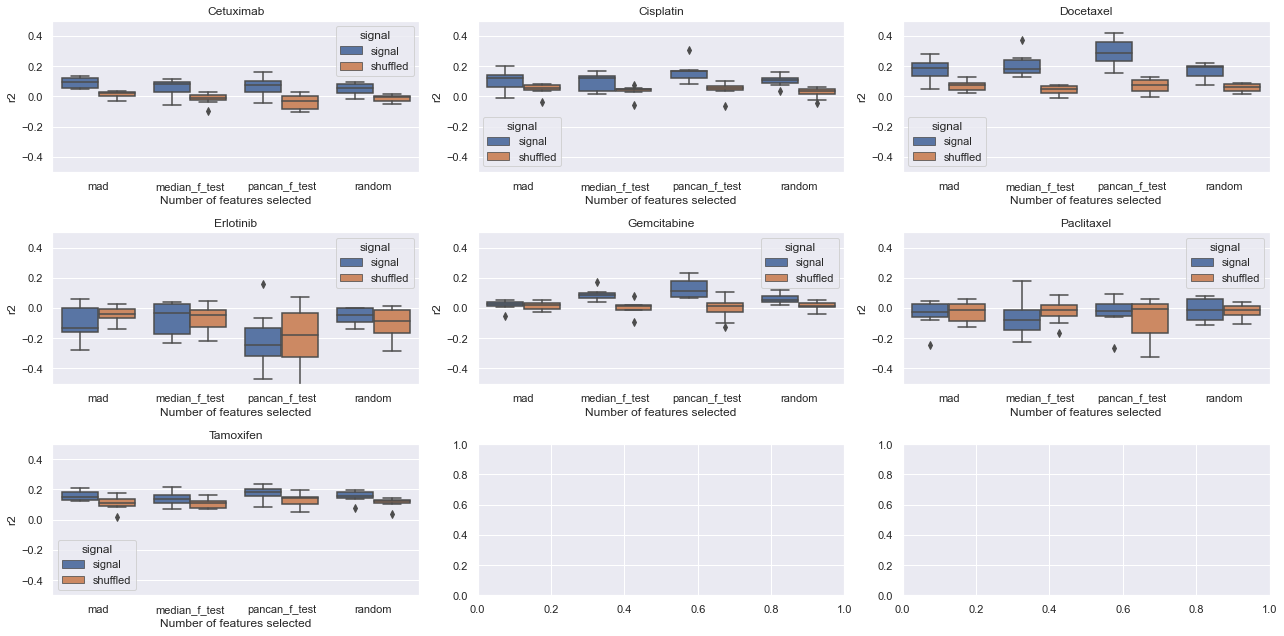

In [5]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(3, 3)

results_df.sort_values(by=['drug', 'fs_method'], inplace=True)
for ix, drug in enumerate(results_df.drug.unique()):
    ax = axarr[ix // 3, ix % 3]
    plot_df = results_df[(results_df.drug == drug) &
                         (results_df.n_dims == n_dims) &
                         (results_df.data_type == 'test')].copy()
    plot_df.loc[:, 'fs_method'] = plot_df.fs_method.str.split('.', 1, expand=True)[0]
    sns.boxplot(data=plot_df, x='fs_method', y='r2',
                hue='signal', hue_order=signal_order,
                ax=ax)
    ax.set_title(drug)
    ax.set_xlabel('Number of features selected')
    ax.set_ylim(-0.5, 0.5)

plt.tight_layout()

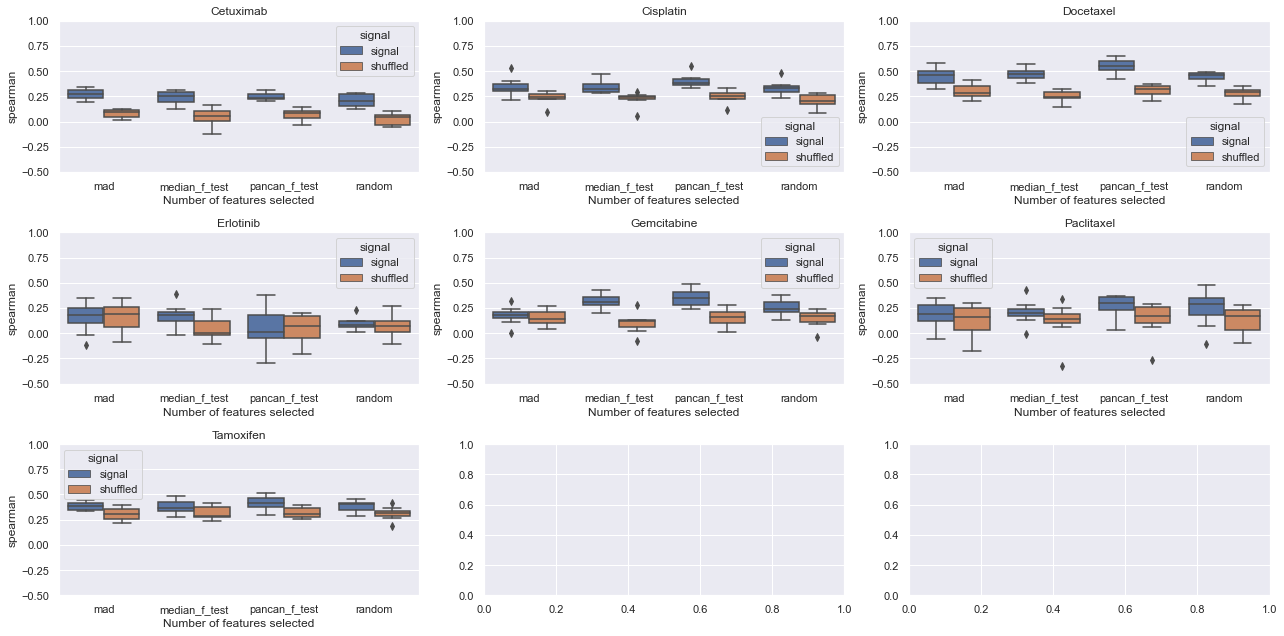

In [6]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(3, 3)

results_df.sort_values(by=['drug', 'fs_method'], inplace=True)
for ix, drug in enumerate(results_df.drug.unique()):
    ax = axarr[ix // 3, ix % 3]
    plot_df = results_df[(results_df.drug == drug) &
                         (results_df.n_dims == n_dims) &
                         (results_df.data_type == 'test')].copy()
    plot_df.loc[:, 'fs_method'] = plot_df.fs_method.str.split('.', 1, expand=True)[0]
    sns.boxplot(data=plot_df, x='fs_method', y='spearman',
                hue='signal', hue_order=signal_order,
                ax=ax)
    ax.set_title(drug)
    ax.set_xlabel('Number of features selected')
    ax.set_ylim(-0.5, 1.0)

plt.tight_layout()

### True labels model performance across dimensions

In these plots we'll plot just the models with the true labels, across multiple feature selection dimensions.

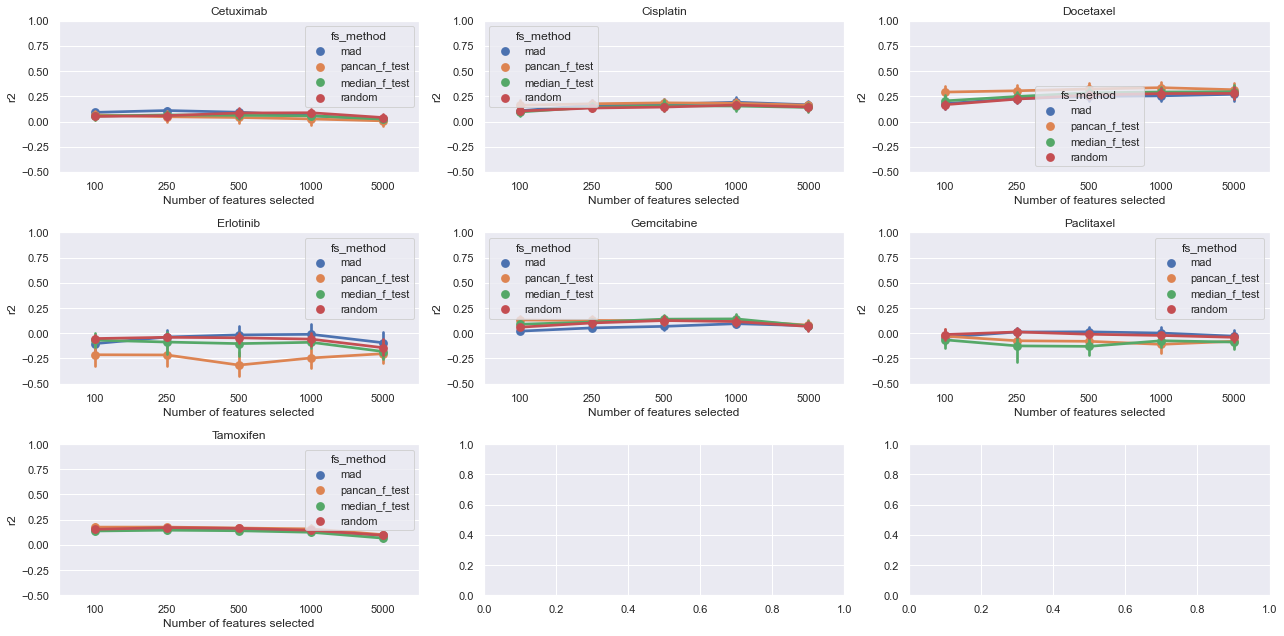

In [7]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(3, 3)

results_df.sort_values(by=['drug', 'fs_method'], inplace=True)
for ix, drug in enumerate(results_df.drug.unique()):
    ax = axarr[ix // 3, ix % 3]
    plot_df = results_df[(results_df.drug == drug) &
                         (results_df.signal == 'signal') &
                         (results_df.data_type == 'test')].copy()
    plot_df.loc[:, 'fs_method'] = plot_df.fs_method.str.split('.', 1, expand=True)[0]
    sns.pointplot(data=plot_df, x='n_dims', y='r2',
                  hue='fs_method', hue_order=fs_method_order, ax=ax)
    ax.set_title(drug)
    ax.set_xlabel('Number of features selected')
    ax.set_ylim(-0.5, 1)

plt.tight_layout()

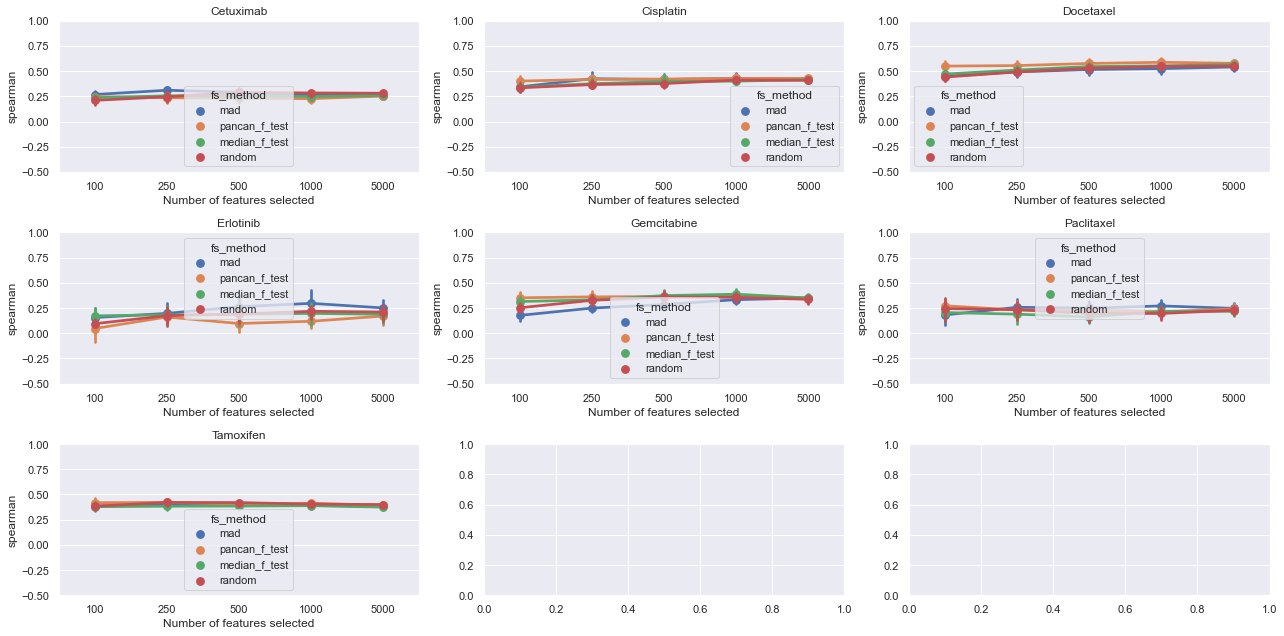

In [8]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(3, 3)

results_df.sort_values(by=['drug', 'fs_method'], inplace=True)
for ix, drug in enumerate(results_df.drug.unique()):
    ax = axarr[ix // 3, ix % 3]
    plot_df = results_df[(results_df.drug == drug) &
                         (results_df.signal == 'signal') &
                         (results_df.data_type == 'test')].copy()
    plot_df.loc[:, 'fs_method'] = plot_df.fs_method.str.split('.', 1, expand=True)[0]
    sns.pointplot(data=plot_df, x='n_dims', y='spearman',
                  hue='fs_method', hue_order=fs_method_order, ax=ax)
    ax.set_title(drug)
    ax.set_xlabel('Number of features selected')
    ax.set_ylim(-0.5, 1)

plt.tight_layout()

### Performance across dimensions after correcting for shuffled baseline

In these plots we'll take the difference between signal and shuffled and plot that. This gives an idea of how much signal our -omics-based models are capturing above a model that just uses average drug response per cancer type.

In [9]:
# get difference between true and shuffled models, split by
# feature selection method
def compare_from_experiment(experiment_df):
    compare_df = []
    for fs_method in experiment_df.fs_method.unique():
        compare_df.append(
            au.compare_control_ind(
                experiment_df[
                    (experiment_df.fs_method == fs_method)
                ], identifier='drug', metric='spearman', verbose=True)
              .assign(fs_method=fs_method)
        )
    return pd.concat(compare_df)

compare_df = compare_from_experiment(results_df)

print(compare_df.shape)
compare_df.head()

(1120, 5)


,identifier,seed,fold,delta_spearman,fs_method
0,Cetuximab,1,0,0.229940,mad.100
1,Cetuximab,1,1,0.181070,mad.100
2,Cetuximab,1,2,0.094912,mad.100
3,Cetuximab,1,3,0.174077,mad.100
4,Cetuximab,42,0,0.251763,mad.100


In [10]:
compare_df[['fs_method', 'n_dims']] = compare_df.fs_method.str.split('.', 1, expand=True)
compare_df['n_dims'] = compare_df.n_dims.astype(int)

print(compare_df.fs_method.unique())
print(compare_df.n_dims.unique())
compare_df.head()

['mad' 'median_f_test' 'pancan_f_test' 'random']
[ 100 1000  250  500 5000]


,identifier,seed,fold,delta_spearman,fs_method,n_dims
0,Cetuximab,1,0,0.229940,mad,100
1,Cetuximab,1,1,0.181070,mad,100
2,Cetuximab,1,2,0.094912,mad,100
3,Cetuximab,1,3,0.174077,mad,100
4,Cetuximab,42,0,0.251763,mad,100


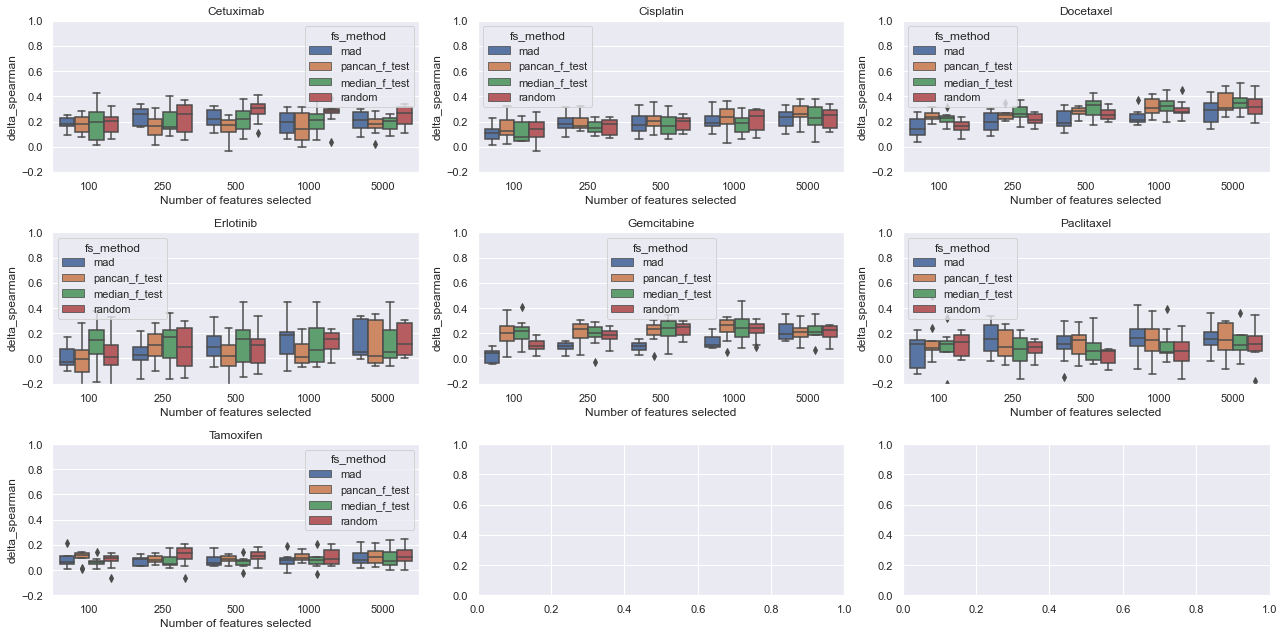

In [11]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(3, 3)

fs_method_order = [
    'mad',
    'pancan_f_test',
    'median_f_test',
    'random'
]

for ix, drug in enumerate(compare_df.identifier.unique()):
    ax = axarr[ix // 3, ix % 3]
    plot_df = compare_df[compare_df.identifier == drug]
    sns.boxplot(data=plot_df, x='n_dims', y='delta_spearman',
                hue='fs_method', hue_order=fs_method_order, ax=ax)
    ax.set_title(drug)
    ax.set_xlabel('Number of features selected')
    ax.set_ylim(-0.2, 1)

plt.tight_layout()